# <font color='Black'> EYE FOR BLIND

**<font color='Black'> Capstone project aims to build,  a deep learning model which can explain the contents of an image in the form of text through caption generation with an encoder-decoder and attention mechanism on Flickr8K dataset. This kind of model is a use-case for blind people so that they can understand any image with the help of speech. The caption generated through a CNN-RNN model will be converted to speech using a text to speech library. First the features are extracted separately by using Inception V3 model then these features are passed to encoder. Afterwards Attention mechanism used and output of attention passed into decoder, where GRU is used to extract the caption based info**


**Steps Involved**

    1.Data Preprocessing: Processing image for inception V3 model, feature extraction and Caption processing for encoder-decoder network
    2.Model Building: Encoder-Decoder-Attention model building
    3.Model Evaluation: Evaluation using Greedy search and BLEU score.
    4.Prediction on unseen data
    5.Caption to speech conversion

In [1]:
#Import all the required libraries
import glob
import cv2
import matplotlib.pyplot as plt
import re
import pandas as pd
from collections import Counter
from collections import OrderedDict
import nltk
import numpy as np
import seaborn as sns

import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers,Model 
from tensorflow.keras.datasets import mnist 
import pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from tensorflow.keras.layers import LSTM,GRU,SimpleRNN
%matplotlib inline
from PIL import Image

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [2]:
#Import the dataset and read the image into a seperate variable

images= r'/home/Capstone/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [3]:
#Visualise both the images & text present in the dataset
def display_images(temp_df):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = cv2.imread(os.path.join(images,'Images',temp_df['image'].iloc[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df['caption'].iloc[i], 20)))
        plt.axis("off")

In [5]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    #your code here
    text_ = open(filename, 'r')
    text = text_.read()
    
    return text

doc = load_doc('captions.txt')
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [6]:
df_cap = pd.read_csv('captions.txt')
df_cap.head(7)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...


In [7]:
all_img_id_raw= re.findall('(.+?\.jpg)', doc, re.IGNORECASE)
all_img_id = set(all_img_id_raw)
len(all_img_id)

8091

In [8]:
cap_list = []
for x in all_img_id:
    cap_sub = []
    for cap in (doc.split("\n")):
        if x in cap:
            t = (cap.split(".jpg,",1)[1])
            p = t.replace(" .", "")
            p = " " + '<start> ' + p + ' <end>' + " "
            cap_sub.append(p)
    cap_list.append(cap_sub)

In [9]:
image_path_for_training = list(df_cap['image'].apply(lambda x: os.path.join(images,x)))

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [10]:
all_img_id= all_img_id#store all the image id here
all_img_vector= all_imgs#store all the image path here
annotations= cap_list#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

,ID,Path,Captions
0,2174206711_11cb712a8d.jpg,/home/Capstone/Images/3428386573_670f5362f0.jpg,"[ <start> ""Two Asian cheerleaders are facing f..."
1,2519483556_2b1632a18c.jpg,/home/Capstone/Images/3329858093_0ec73f2190.jpg,"[ <start> The three girls have pillows <end> ,..."
2,3241726740_6d256d61ec.jpg,/home/Capstone/Images/2929006980_9f9f8f3d21.jpg,[ <start> A man smoking a cigarette talking to...
3,2286239223_d84ffc4e4a.jpg,/home/Capstone/Images/1094462889_f9966dafa6.jpg,"[ <start> A man and a woman on a bench <end> ,..."
4,578644583_da3ff18dd1.jpg,/home/Capstone/Images/487487795_54705c406e.jpg,[ <start> A child is jumping into a swimming p...


In [11]:
df.Captions[0]

[' <start> "Two Asian cheerleaders are facing forward waving silver pom-poms , whilst other cheerleaders are performing facing the other way" <end> ',
 ' <start> Two asian cheerleaders are holding out silver pompoms <end> ',
 ' <start> Two asian girls cheerleading for a sporting event <end> ',
 ' <start> Two girls dressed in light brown wearing black neckties hold foil pom poms while doing a routine with others <end> ',
 ' <start> Two young girl cheerleaders wearing a khaki shirt with a black tie cheering <end> ']

In [12]:
#Create a list which contains all the captions
cap_list01 = []
for x in cap_list:
    for i in x:
#         i = " "+"seqstart " + i + " seqend"+" "
        cap_list01.append(i)
        
annotations= cap_list01#write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path = all_imgs#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))
print(annotations[:6])

Total captions present in the dataset: 40455
Total images present in the dataset: 8091
[' <start> "Two Asian cheerleaders are facing forward waving silver pom-poms , whilst other cheerleaders are performing facing the other way" <end> ', ' <start> Two asian cheerleaders are holding out silver pompoms <end> ', ' <start> Two asian girls cheerleading for a sporting event <end> ', ' <start> Two girls dressed in light brown wearing black neckties hold foil pom poms while doing a routine with others <end> ', ' <start> Two young girl cheerleaders wearing a khaki shirt with a black tie cheering <end> ', ' <start> The three girls have pillows <end> ']


In [13]:
# cap_list02 = [cap_list01[i * 5:(i + 1) * 5] for i in range((len(cap_list01) + 5 - 1)// 5 )]

In [14]:
#Create the vocabulary & the counter for the captions
x_list = []
annot_one_string = ''
for x in annotations:
    annot_one_string = annot_one_string + x
#     annot_one_string = annot_one_string.replace("<start>", "")
#     annot_one_string = annot_one_string.replace("<end>", "")
vocab = annot_one_string.split()

In [15]:
#Creating own stop words list
stop_words = ['A','at','it','the','The','of','to','and','we','a','in','our','not','that','on','is','are','with','_',',',':','-','>','/','`']

Text(0.5, 1.0, 'Word count without text processing')

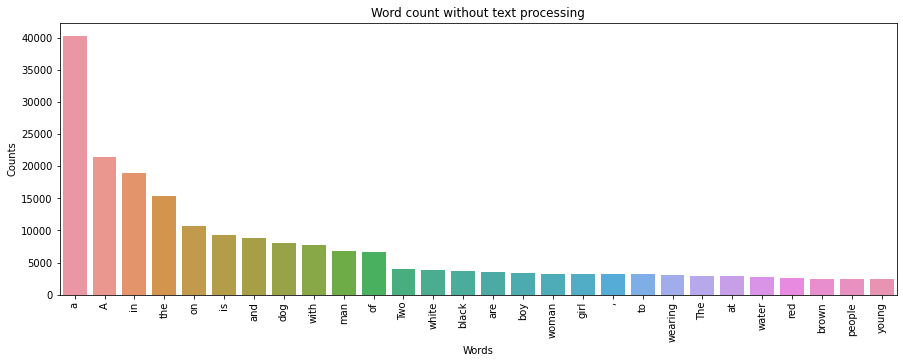

In [16]:
#Creating count plot for words
# freq = nltk.FreqDist(vocab)
# clean_words = [w for w in vocab if not w in stop_words]
val_count  = nltk.FreqDist(vocab)
val_count_ = pd.Series(dict(val_count.most_common(30)))
val_count_ = val_count_.drop('<start>')
val_count_ = val_count_.drop('<end>')
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15,5))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=val_count_.index, y=val_count_.values, ax=ax)
plt.xticks(rotation=90);
ax.set(xlabel='Words', ylabel='Counts')
plt.title("Word count without text processing") 

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [17]:
# create the tokenizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokenized_words = word_tokenize(annot_one_string)

[nltk_data] Downloading package punkt to /home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
#Creating annotation string on which tokenizer can be fitted
annot = df_cap['caption']
annotations_new=list(annot.apply(lambda x: "<start> "+ x + " <end>"))

In [19]:
# create the tokenizer
tokenizer = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token="UNK")

# Tokenising sentences
tokenizer.fit_on_texts(annotations_new)

In [20]:
tokenizer.sequences_to_texts(tokenizer.texts_to_sequences((annotations_new)))

['<start> a child in a pink dress is climbing up a set of stairs in an UNK way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>',
 '<start> a black dog and a spotted dog are fighting <end>',
 '<start> a black dog and a tri colored dog playing with each other on the road <end>',
 '<start> a black dog and a white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>',
 '<start> a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl <end>',
 '<start> a little girl is sitting in front of a large painted rainbow <end>',
 '<start> a small girl in the grass plays with fingerpaints in fro

In [21]:
# Create word-to-index and index-to-word mappings.
print(tokenizer.word_index)

{'UNK': 1, 'a': 2, '<start>': 3, '<end>': 4, 'in': 5, 'the': 6, 'on': 7, 'is': 8, 'and': 9, 'dog': 10, 'with': 11, 'man': 12, 'of': 13, 'two': 14, 'white': 15, 'black': 16, 'boy': 17, 'are': 18, 'woman': 19, 'girl': 20, 'to': 21, 'wearing': 22, 'at': 23, 'people': 24, 'water': 25, 'red': 26, 'young': 27, 'brown': 28, 'an': 29, 'his': 30, 'blue': 31, 'dogs': 32, 'running': 33, 'through': 34, 'playing': 35, 'while': 36, 'shirt': 37, 'down': 38, 'standing': 39, 'ball': 40, 'little': 41, 'grass': 42, 'snow': 43, 'child': 44, 'person': 45, 'jumping': 46, 'over': 47, 'three': 48, 'front': 49, 'sitting': 50, 'holding': 51, 'up': 52, 'field': 53, 'small': 54, 'by': 55, 'large': 56, 'green': 57, 'one': 58, 'group': 59, 'yellow': 60, 'her': 61, 'walking': 62, 'children': 63, 'men': 64, 'into': 65, 'air': 66, 'beach': 67, 'near': 68, 'mouth': 69, 'jumps': 70, 'another': 71, 'for': 72, 'street': 73, 'runs': 74, 'its': 75, 'from': 76, 'riding': 77, 'stands': 78, 'as': 79, 'bike': 80, 'girls': 81, '

In [22]:
# check = nltk.FreqDist(tokenized_words)
# vocab_most_common = Counter(tokenized_words).most_common()
# vocab_most_5000 = []
# for x in vocab_most_common[:5000]:
#     vocab_most_5000.append(x[0])

Text(0.5, 1.0, 'Cleaned Word count after text processing')

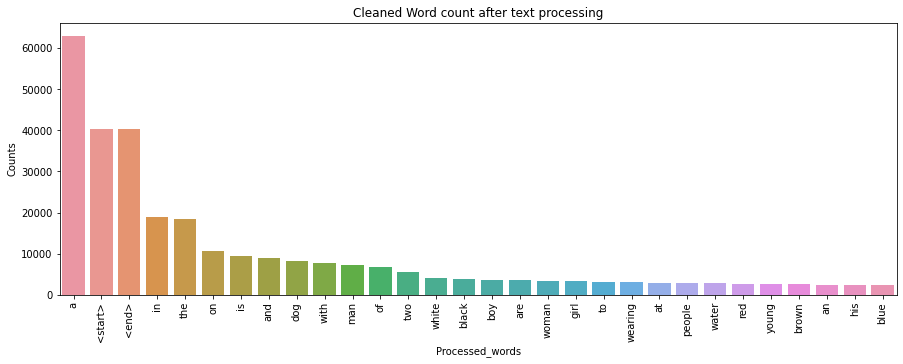

In [23]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_temp = dict(tokenizer.word_counts)
#your code here
clean_words  = nltk.FreqDist(word_temp)
clean_words = pd.Series(dict(clean_words.most_common(30)))
## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15,5))
all_plot = sns.barplot(x=clean_words.index, y=clean_words.values, ax=ax)
plt.xticks(rotation=90);
ax.set(xlabel='Processed_words', ylabel='Counts')
plt.title("Cleaned Word count after text processing") 

In [24]:
sent_tokenized=tokenizer.texts_to_sequences(annotations_new)

In [25]:
# Calculating  max_length of the captions for padding afterwards
max_len = 0
for x in sent_tokenized:
    if len(x) > max_len:
        max_len = len(x)
max_len

39

In [26]:
#Padding sequence to maintain uniform length
cap_vector= pad_sequences(sent_tokenized, maxlen=max_len,padding='post')
cap_vector[0]

array([  3,   2,  44,   5,   2,  91, 173,   8, 120,  52,   2, 394,  13,
       395,   5,  29,   1, 671,   4,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [27]:
#write your code here to create the dataset consisting of image paths
tf_image_vector = tf.data.Dataset.from_tensor_slices(all_img_vector)
for i in tf_image_vector.take(5):
    print(i)

tf.Tensor(b'/home/Capstone/Images/3428386573_670f5362f0.jpg', shape=(), dtype=string)
tf.Tensor(b'/home/Capstone/Images/3329858093_0ec73f2190.jpg', shape=(), dtype=string)
tf.Tensor(b'/home/Capstone/Images/2929006980_9f9f8f3d21.jpg', shape=(), dtype=string)
tf.Tensor(b'/home/Capstone/Images/1094462889_f9966dafa6.jpg', shape=(), dtype=string)
tf.Tensor(b'/home/Capstone/Images/487487795_54705c406e.jpg', shape=(), dtype=string)


2023-07-18 14:13:19.621357: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-18 14:13:19.621461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9842 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


/home/Capstone/Images/1478268555_7e301fc510.jpg


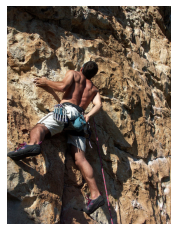

In [28]:
#write your code here for creating the function. This function should return images & their path
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    return img, image_path


def plot_captionPath(img,path):
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
#     for i in get_labels(path):
#         print(i)

img,path=load_image(df['Path'].sample(1).values[0])
print(path)
plot_captionPath(img,path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


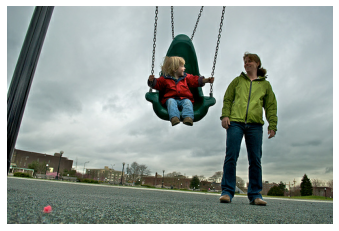

In [86]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
def trasnform_image(img_path):
    img,path = load_image(img_path)
    img = tf.keras.layers.Resizing(299, 299)(img)
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    #img = tf.keras.layers.experimental.preprocessing.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, path

img,path = trasnform_image('Images/3399284917_721aefe2a7.jpg')
plot_captionPath(img,path)
d, y = load_image('Images/3399284917_721aefe2a7.jpg')
plot_captionPath(d, y) #plotting original image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


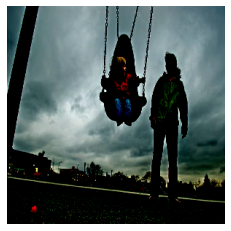

In [85]:
#plotting processed  image
plot_captionPath(img,path)

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

In [31]:
image_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [32]:
new_input = image_model.inputs#write code here to get the input of the image_model
hidden_layer = image_model.output#write code here to get the output of the image_model

image_features_extract_model = Model(inputs = new_input, outputs = hidden_layer)#build the final model using both input & output layer

In [33]:
feature_vector_path = '/home/Capstone/Features/'

In [34]:
image_dataset = tf_image_vector.map(trasnform_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)
for i in image_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(64, 299, 299, 3), dtype=float32, numpy=
array([[[[-9.73834336e-01, -9.58148062e-01, -9.65991199e-01],
         [-9.68627453e-01, -9.52941179e-01, -9.60791767e-01],
         [-9.68627453e-01, -9.52941179e-01, -9.61676180e-01],
         ...,
         [-9.83862698e-01, -9.68788505e-01, -9.60618138e-01],
         [-9.98662233e-01, -9.68181491e-01, -9.76024628e-01],
         [-9.92156863e-01, -9.60784316e-01, -9.68627453e-01]],

        [[-9.72946227e-01, -9.57259953e-01, -9.65103090e-01],
         [-9.67300832e-01, -9.51614559e-01, -9.62242067e-01],
         [-9.68627453e-01, -9.52941179e-01, -9.76470590e-01],
         ...,
         [-9.80470598e-01, -9.70976830e-01, -9.62379158e-01],
         [-9.76459444e-01, -9.60795462e-01, -9.68627453e-01],
         [-9.89930868e-01, -9.61233914e-01, -9.69077051e-01]],

        [[-9.70107675e-01, -9.54421401e-01, -9.62264538e-01],
         [-9.63060915e-01, -9.47374642e-01, -9.70904052e-01],
         [-9.68627453e-01, -9.52941179e-

In [35]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

def feature_extract(dataset):
    from tqdm.notebook import tqdm
    for img, path in tqdm(dataset):
        batch_features = image_features_extract_model(img)
        batch_features = tf.reshape(batch_features,
                                  (batch_features.shape[0], -1, batch_features.shape[3]))
        for bf, p in zip(batch_features, path):

            path_store = p.numpy().decode("utf-8")
            np.save(path_store, bf.numpy())
#             with open (os.path.join(feature_vector_path,'features_dict.pkl'),'wb') as f:
#                 pickle.dump(batch_features,f)

In [36]:
# feature_extract(image_dataset)

In [37]:
# load features from pickle
feature_vector_file = os.path.join(feature_vector_path,'features_dict.pkl')

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [38]:
#write your code here
X = image_path_for_training
y = cap_vector
path_train, path_test, cap_train, cap_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [39]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [40]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption
def map_func(img_path,caption):
    img_tensor = np.load(img_path.decode("utf-8")+".npy")
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [41]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000 
AUTOTUNE = tf.data.AUTOTUNE

In [42]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(image_path, captions, buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE):
    # your code goes here to create the dataset & transform it
    tf_dataset=tf.data.Dataset.from_tensor_slices((image_path,captions))
    
    dataset=tf_dataset.map(lambda x, y:tf.numpy_function(map_func, 
                                                                [x, y], 
                                                                [tf.float32, tf.int32]), 
                          num_parallel_calls = tf.data.AUTOTUNE)
    
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [43]:
k = gen_dataset(path_train, cap_train)

In [44]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [45]:
for sample_img_batch, sample_cap_batch in train_dataset.take(1):
    print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
    print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [46]:
embedding_dim = 256 
units = 512
vocab_size = 5000+1#top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Encoder

In [47]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)#build Dense layer with relu activation
        
    def call(self, features):
        features_raw =  self.dense(features)# extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features_raw)
        return features

In [48]:
encoder=Encoder(embedding_dim)

### Attention model

In [49]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build Dense layer
        self.V = tf.keras.layers.Dense(1)#build final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score_add = tf.keras.layers.Add()([self.W1(features), self.W2(hidden_with_time_axis)])
        score_tanh = tf.keras.activations.tanh(score_add)
        score = self.V(score_tanh)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,  axis=1)# extract attention weights with shape: (batch_size, 8*8, 1)
        context_vector = tf.keras.layers.Multiply()([features, attention_weights])#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

In [50]:
# context_vector, attention_weights = Attention_model(units, features)

### Decoder

In [51]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)#tf.keras.layers.Concatenate()([tf.expand_dims(context_vector, 1), embed])# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


2023-07-18 14:13:26.034497: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [54]:
#Creating omptimizer as Adam and loss object with Sparse categorical entropy as a metric
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [55]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [56]:
#Creating checkpoint mechanism to save best model weights
checkpoint_path_ckpt = "/home/Capstone/ChkPt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [57]:
#Using earlier version for epoch in case better results already available
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [58]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            pred, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], pred)
            dec_input = tf.expand_dims(target[:, i], 1)
        #write your code here to do the training steps
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [59]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0]) #target.shape[0]=64, hidden shape = (64,512)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) #dec_input shape = (64,1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor) # feature_shape=(64,64,2048)

        for x in range(1, target.shape[1]): 
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden) 

            loss += loss_function(target[:, x], predictions)

            # # using teacher forcing
            # dec_input = tf.expand_dims(target[:, i], 1)
            id_ = tf.argmax(predictions,1) 
            dec_input = tf.expand_dims(id_, 1)
            
    total_loss = (loss / int(target.shape[1])) 
        
    return loss, total_loss

In [60]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor,target)
        total_loss += t_loss

    # average loss calc
    avg_test_loss=total_loss / test_num_steps
    
    
    return avg_test_loss

In [61]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/13 [00:00<?, ?it/s]

For epoch: 3, the train loss is 1.279, & test loss is 1.878
Time taken for 1 epoch 172.56834483146667 sec

Test loss has been reduced from 100.000 to 1.878


 15%|█▌        | 2/13 [03:59<20:15, 110.47s/it]

For epoch: 4, the train loss is 0.996, & test loss is 1.942
Time taken for 1 epoch 66.6502959728241 sec



 23%|██▎       | 3/13 [05:09<15:19, 91.95s/it] 

For epoch: 5, the train loss is 0.904, & test loss is 1.968
Time taken for 1 epoch 69.91647171974182 sec



 31%|███       | 4/13 [06:15<12:16, 81.78s/it]

For epoch: 6, the train loss is 0.840, & test loss is 1.918
Time taken for 1 epoch 66.17943787574768 sec



 38%|███▊      | 5/13 [07:21<10:08, 76.07s/it]

For epoch: 7, the train loss is 0.788, & test loss is 1.929
Time taken for 1 epoch 65.94047594070435 sec



 46%|████▌     | 6/13 [08:31<08:37, 73.88s/it]

For epoch: 8, the train loss is 0.742, & test loss is 1.962
Time taken for 1 epoch 69.62542080879211 sec



 54%|█████▍    | 7/13 [09:39<07:11, 72.00s/it]

For epoch: 9, the train loss is 0.701, & test loss is 2.052
Time taken for 1 epoch 68.11436986923218 sec



 62%|██████▏   | 8/13 [10:46<05:51, 70.34s/it]

For epoch: 10, the train loss is 0.664, & test loss is 2.050
Time taken for 1 epoch 66.77955079078674 sec



 69%|██████▉   | 9/13 [11:54<04:38, 69.70s/it]

For epoch: 11, the train loss is 0.628, & test loss is 2.083
Time taken for 1 epoch 68.28206968307495 sec



 77%|███████▋  | 10/13 [12:59<03:25, 68.35s/it]

For epoch: 12, the train loss is 0.595, & test loss is 2.157
Time taken for 1 epoch 65.32976174354553 sec



 85%|████████▍ | 11/13 [14:08<02:17, 68.56s/it]

For epoch: 13, the train loss is 0.564, & test loss is 2.247
Time taken for 1 epoch 69.01922821998596 sec



 92%|█████████▏| 12/13 [15:14<01:07, 67.71s/it]

For epoch: 14, the train loss is 0.535, & test loss is 2.294
Time taken for 1 epoch 65.78184127807617 sec



100%|██████████| 13/13 [16:25<00:00, 75.79s/it]

For epoch: 15, the train loss is 0.507, & test loss is 2.363
Time taken for 1 epoch 70.50703620910645 sec



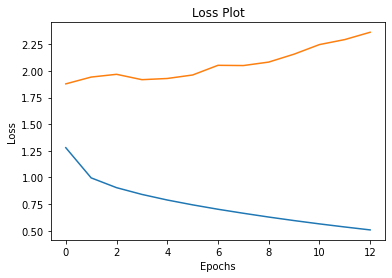

In [62]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [63]:
def evaluate(image, attention_shape=64):
    attention_plot = np.zeros((max_len, attention_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(trasnform_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val_9 = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val_9, (img_tensor_val_9.shape[0], -1, img_tensor_val_9.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder
    

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder
 

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        pred_word = tf.compat.as_text(tokenizer.index_word[predicted_id])
        result.append(pred_word)

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search(optional)

In [81]:
def beam_evaluate(image, beam_index = 3):
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(trasnform_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val_raw = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val_raw, (img_tensor_val_raw.shape[0], -1, img_tensor_val_raw.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    attention_plot = np.zeros((max_len, 64))
    
    while len(result[0][0]) < max_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

            pred_raw = np.argsort(predictions[0])[-beam_index:]

            for w in pred_raw:
                next_caption, prob = s[0][:], s[1]
                next_caption.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_caption, prob])
                #print('The next cap is ', [tokenizer.index_word[i] for i in next_cap])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    attention_plot = attention_plot[:len(result[-1][0]), :]

    caption = ' '.join(final_caption[1:])

    return caption

In [65]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

In [66]:
from nltk.translate.bleu_score import sentence_bleu

In [67]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 42.857142857142854
Real Caption: two guys playing horseshoe
Prediction Caption: two guys are playing horse shoe shore


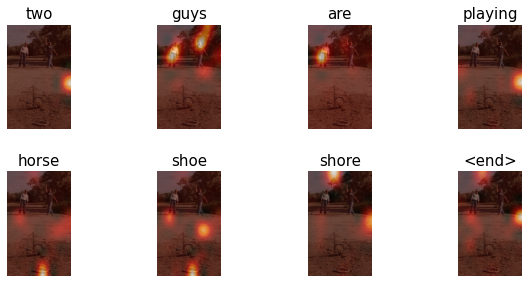

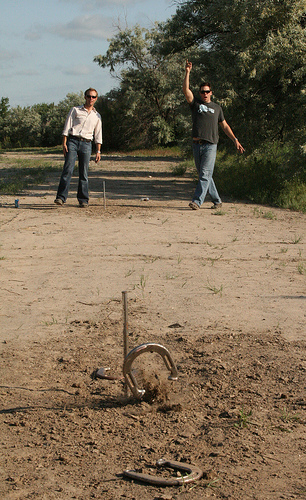

In [77]:
rid = np.random.randint(0, len(path_test))
# rid = 8064
test_image = path_test[rid]
# test_image = '/home/Capstone/Images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot, pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1,0,0,0))
print(f"BELU score: {score*100}")
print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [82]:
captions=beam_evaluate(test_image)
print(captions)

two young are playing horse


## Caption to speech

In [70]:
!pip install gTTs
!pip install playsound
from gtts import gTTS
from playsound import playsound
from IPython import display

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [79]:
#Caption text to voice
def caption_2_voice(caption):
    speech = gTTS("The image is about: "+ caption, lang = 'en') 
    speech.save('caption_2_voice.mp3')
    display.display(display.Audio('caption_2_voice.mp3', rate=None, autoplay=False))

In [80]:
caption_2_voice(pred_caption)